In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [4]:
#학습데이터 로드 판다스의 피처파일 사용
data_dir = Path('../data/dacon-dku')
feature_dir = Path('../build/feature')
val_dir = Path('../build/val')
tst_dir = Path('../build/tst')
sub_dir = Path('../build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [5]:
algo_name = 'lgbcv'
feature_name = 'stacking1'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [6]:
#Stacking Feature 생성
model_names = ['lrcv_polyfeature', 'rfcv_feature', 'lgbcv_feature']
trn = []
tst = []
feature_names = []
for model in model_names:
    trn.append(np.loadtxt(val_dir / f'{model}.val.csv', delimiter=','))
    tst.append(np.loadtxt(tst_dir / f'{model}.tst.csv', delimiter=','))
    feature_names += [f'{model}_class0', f'{model}_class1', f'{model}_class2']
    
trn = np.hstack(trn)
tst = np.hstack(tst)
feature_names

['lrcv_polyfeature_class0',
 'lrcv_polyfeature_class1',
 'lrcv_polyfeature_class2',
 'rfcv_feature_class0',
 'rfcv_feature_class1',
 'rfcv_feature_class2',
 'lgbcv_feature_class0',
 'lgbcv_feature_class1',
 'lgbcv_feature_class2']

In [7]:
y = pd.read_csv(trn_file, index_col=0, usecols=['id', target_col]).values.flatten()
y.shape

(320000,)

In [8]:
#Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [9]:
#LightGBM 모델 학습
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=1000,
                             num_leaves=64,
                             learning_rate=0.1,
                             min_child_samples=10,
                             subsample=.5,
                             subsample_freq=1,
                             colsample_bytree=.8,
                             random_state=seed,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.8368
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.725509
[3]	valid_0's multi_logloss: 0.637988
[4]	valid_0's multi_logloss: 0.566957
[5]	valid_0's multi_logloss: 0.508595
[6]	valid_0's multi_logloss: 0.460574
[7]	valid_0's multi_logloss: 0.419841
[8]	valid_0's multi_logloss: 0.385459
[9]	valid_0's multi_logloss: 0.356308
[10]	valid_0's multi_logloss: 0.331564
[11]	valid_0's multi_logloss: 0.310218
[12]	valid_0's multi_logloss: 0.291879
[13]	valid_0's multi_logloss: 0.276012
[14]	valid_0's multi_logloss: 0.262391
[15]	valid_0's multi_logloss: 0.250533
[16]	valid_0's multi_logloss: 0.240195
[17]	valid_0's multi_logloss: 0.23125
[18]	valid_0's multi_logloss: 0.223532
[19]	valid_0's multi_logloss: 0.216704
[20]	valid_0's multi_logloss: 0.210771
[21]	valid_0's multi_logloss: 0.205548
[22]	valid_0's multi_logloss: 0.200916
[23]	valid_0's multi_logloss: 0.196898
[24]	valid_0's multi_logloss:

[61]	valid_0's multi_logloss: 0.166087
[62]	valid_0's multi_logloss: 0.165986
[63]	valid_0's multi_logloss: 0.165911
[64]	valid_0's multi_logloss: 0.165848
[65]	valid_0's multi_logloss: 0.165788
[66]	valid_0's multi_logloss: 0.165802
[67]	valid_0's multi_logloss: 0.16573
[68]	valid_0's multi_logloss: 0.167349
[69]	valid_0's multi_logloss: 0.165698
[70]	valid_0's multi_logloss: 0.165698
[71]	valid_0's multi_logloss: 0.166773
[72]	valid_0's multi_logloss: 0.166871
[73]	valid_0's multi_logloss: 0.166822
[74]	valid_0's multi_logloss: 0.166291
[75]	valid_0's multi_logloss: 0.165771
[76]	valid_0's multi_logloss: 0.170042
[77]	valid_0's multi_logloss: 0.167118
[78]	valid_0's multi_logloss: 0.1745
[79]	valid_0's multi_logloss: 0.170032
[80]	valid_0's multi_logloss: 0.169977
Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.165698
training model for CV #4
[1]	valid_0's multi_logloss: 0.836482
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_loglo

In [10]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.0284%


In [11]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [12]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

<AxesSubplot:ylabel='feature'>

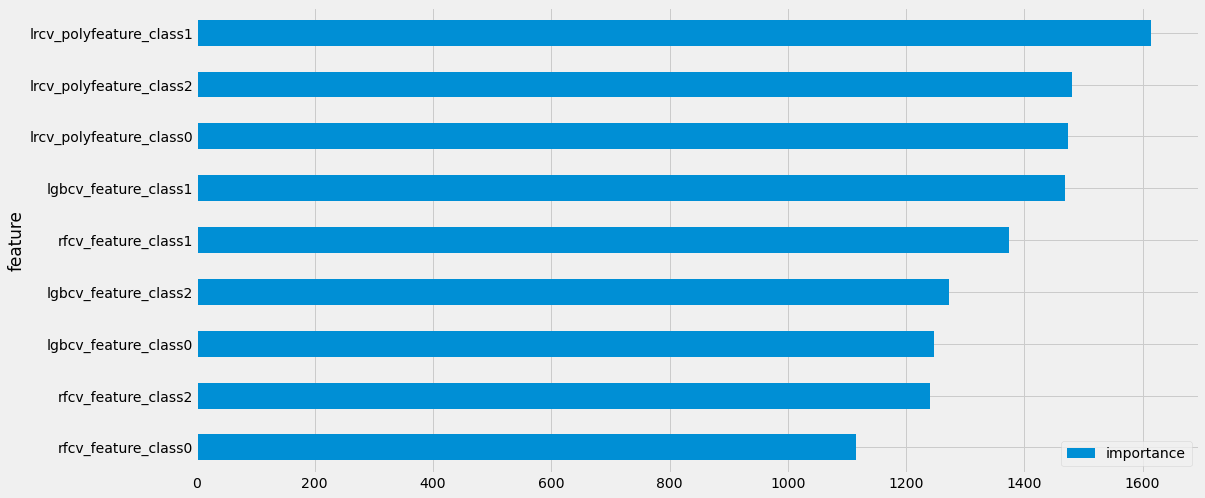

In [14]:
#피처 중요도 시각화
imp = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [15]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [16]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [17]:
sub[target_col].value_counts()

2    40959
0    29980
1     9061
Name: class, dtype: int64

In [18]:
sub.to_csv(sub_file)